# Hand Gesture Recognition CNN Training with ShuffleNet V2
***This is the model training for Open Source Robot Study***
**Author**: Richard Zhou

**Mail**: zhour2@rose-hulman.edu

## Step 0: Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Load the dataset
Currently 6 kinds of gestures are supported.

| Label | Name          | Description                                        | Meaning (Expected Robot's responding)                   |
| ----- | ------------- | -------------------------------------------------- | ------------------------------------------------------- |
| 1     | Greeting      | Open Hand                                          | Robot's joyful response is expected.                    |
| 2     | Stop Sign     | Closed Fist                                        | Robot should stop the current behavior.                 |
| 3     | Praise        | Thumbs Up                                          |                                                         |
| 4     | Win SIgn      | "V"                                                |                                                         |
| 5     | "Rock n Roll" | Closed Fist with Index and Little finger stretched | Robot starts to dance.                                  |
| 6     | Be good       | Thumbs Down                                        | Robot would stop the current behavior and acting fears. |

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set path of the dataset
dataset_path = '/content/drive/MyDrive/HGRModelTraining/HandGestureDataset'

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2, # using 20% of the data for validation
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224), #ShuffleNetV2 standard input size
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation')


Found 314 images belonging to 6 classes.
Found 74 images belonging to 6 classes.


## Step 2: Create the ShuffleNet V2 Model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def channel_shuffle(x, groups):
    height, width, in_channels = x.shape[1], x.shape[2], x.shape[3]
    channels_per_group = in_channels // groups

    # reshape
    x = tf.reshape(x, [-1, height, width, groups, channels_per_group])

    # transpose
    x = tf.transpose(x, [0, 1, 2, 4, 3])

    # flatten
    x = tf.reshape(x, [-1, height, width, in_channels])

    return x

def shuffle_unit(inputs, in_channels, out_channels, strides, groups):
    if strides == 2:
        left_branch = layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same')(inputs)
        left_branch = layers.BatchNormalization()(left_branch)
        left_branch = layers.ReLU()(left_branch)
        left_branch = layers.Conv2D(out_channels//2, (1, 1), padding='same')(left_branch)
        left_branch = layers.BatchNormalization()(left_branch)

        right_branch = layers.Conv2D(out_channels//2, (1, 1), padding='same')(inputs)
        right_branch = layers.BatchNormalization()(right_branch)
        right_branch = layers.ReLU()(right_branch)
        right_branch = layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same')(right_branch)
        right_branch = layers.BatchNormalization()(right_branch)
        right_branch = layers.Conv2D(out_channels//2, (1, 1), padding='same')(right_branch)
        right_branch = layers.BatchNormalization()(right_branch)

        outputs = layers.concatenate([left_branch, right_branch])
    else:
        left_branch = inputs
        right_branch = layers.Conv2D(out_channels//2, (1, 1), padding='same')(inputs)
        right_branch = layers.BatchNormalization()(right_branch)
        right_branch = layers.ReLU()(right_branch)
        right_branch = layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same')(right_branch)
        right_branch = layers.BatchNormalization()(right_branch)
        right_branch = layers.Conv2D(out_channels//2, (1, 1), padding='same')(right_branch)
        right_branch = layers.BatchNormalization()(right_branch)

        outputs = layers.concatenate([left_branch, right_branch])

    outputs = channel_shuffle(outputs, groups)

    return outputs

def ShuffleNetV2(input_shape=(224, 224, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = shuffle_unit(x, in_channels=24, out_channels=48, strides=2, groups=2)
    x = shuffle_unit(x, in_channels=48, out_channels=48, strides=1, groups=2)

    # Stage 3
    x = shuffle_unit(x, in_channels=48, out_channels=96, strides=2, groups=2)
    for _ in range(3):
        x = shuffle_unit(x, in_channels=96, out_channels=96, strides=1, groups=2)

    # Stage 4
    x = shuffle_unit(x, in_channels=96, out_channels=192, strides=2, groups=2)
    for _ in range(7):
        x = shuffle_unit(x, in_channels=192, out_channels=192, strides=1, groups=2)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = ShuffleNetV2(input_shape=(224, 224, 3), num_classes=6)  # Change num_classes based on your dataset
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_121 (Conv2D)         (None, 112, 112, 24)         672       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_185 (B  (None, 112, 112, 24)         96        ['conv2d_121[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_72 (ReLU)             (None, 112, 112, 24)         0         ['batch_normalization_18

## Step 3: Train the model

### 3.1 Train the Model

In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=66,
    verbose=1)

Epoch 1/66
9/9 [==============================] - 35s 840ms/step - loss: 0.0305 - accuracy: 0.9858 - val_loss: 3.3755 - val_accuracy: 0.6406
Epoch 2/66
9/9 [==============================] - 5s 620ms/step - loss: 0.0312 - accuracy: 0.9858 - val_loss: 0.8624 - val_accuracy: 0.7812
Epoch 3/66
9/9 [==============================] - 9s 1s/step - loss: 0.0368 - accuracy: 0.9858 - val_loss: 2.4759 - val_accuracy: 0.6406
Epoch 4/66
9/9 [==============================] - 5s 602ms/step - loss: 0.0134 - accuracy: 0.9965 - val_loss: 0.9062 - val_accuracy: 0.8281
Epoch 5/66
9/9 [==============================] - 5s 603ms/step - loss: 0.0321 - accuracy: 0.9858 - val_loss: 3.1351 - val_accuracy: 0.4688
Epoch 6/66
9/9 [==============================] - 7s 755ms/step - loss: 0.0209 - accuracy: 0.9929 - val_loss: 2.4978 - val_accuracy: 0.5938
Epoch 7/66
9/9 [==============================] - 7s 750ms/step - loss: 0.0341 - accuracy: 0.9894 - val_loss: 3.6850 - val_accuracy: 0.5938
Epoch 8/66
9/9 [======

### 3.2 Review Training Procedure

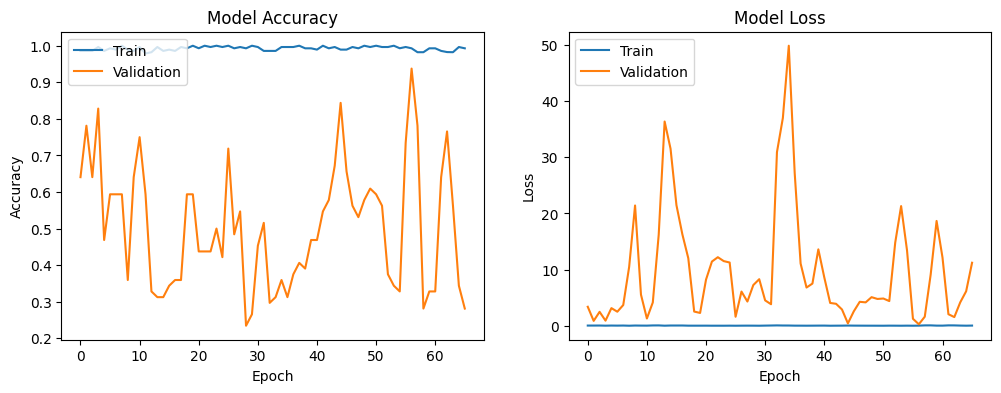

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Step 4: Evaluate and Save the Model

### 4.1 Evaluate the Model

In [32]:
# Evaluate the model
scores = model.evaluate(validation_generator)

print('Loss:', scores[0])
print('Accuracy:', scores[1])

3/3 [==============================] - 1s 291ms/step - loss: 11.2490 - accuracy: 0.2568
Loss: 11.249048233032227
Accuracy: 0.2567567527294159


### 4.2 Pick 10 images in validate dataset randomly

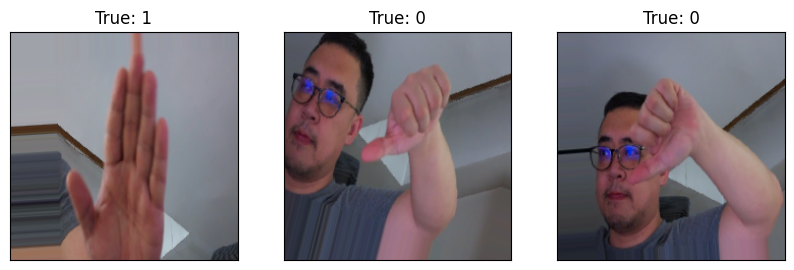

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_images(images, labels, predictions=None):
    """Plot images with their labels. Show predictions if provided."""
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        true_label = labels[i]
        if predictions is not None:
            plt.title(f"True: {true_label}\nPred: {predictions[i]}")
        else:
            plt.title(f"True: {true_label}")
    plt.show()

# Fetching 10 random images and their labels from the validation dataset
random_indices = random.sample(range(len(validation_generator)), 3)
images, labels = [], []
for idx in random_indices:
    img, label = validation_generator[idx]
    images.append(img[0])  # img is a batch of images, we take the first
    labels.append(label[0])  # label is a batch of labels, we take the first

# Convert labels from one-hot encoding to class indices if necessary
labels = np.argmax(labels, axis=1)

# Plot the images and labels
plot_images(images, labels)


### 4.3 Save the Model

In [35]:
# Save the model
model.save('/content/drive/MyDrive/HGRModelTraining/model.h5')